# Imports

In [69]:
from typing import List
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import RocCurveDisplay, mean_absolute_error as mae

# Data loading and preprocessing for predicting events

## Train

In [361]:
events = pd.read_csv("../data/events_train.csv", parse_dates=True)
counters_train = pd.read_csv("../data/counters_train.csv", parse_dates=True)

In [362]:
counters_in = counters_train[counters_train.direction == 'in'][['dt', 'cnt']]
counters_out = counters_train[counters_train.direction == 'out'][['dt', 'cnt']]
counters_in['dt'] = counters_in.dt.apply(pd.to_datetime)
counters_out['dt'] = counters_out.dt.apply(pd.to_datetime)
counters_in = counters_in.set_index('dt')
counters_out = counters_out.set_index('dt')

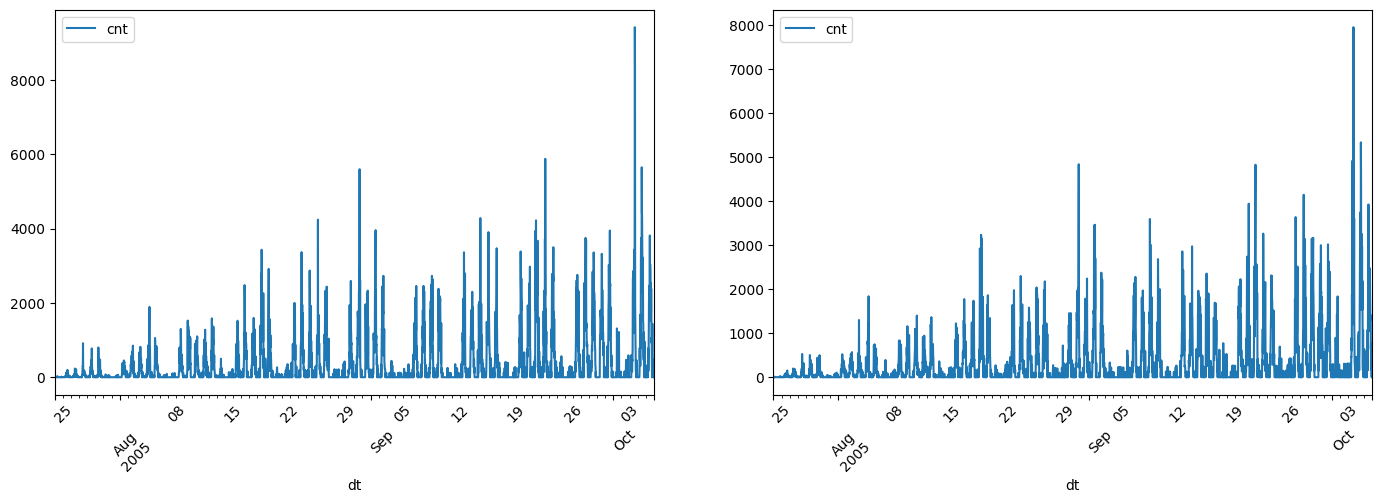

In [363]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
counters_in.plot(rot=45, ax=ax[0])
counters_out.plot(rot=45, ax=ax[1])
plt.show()

<AxesSubplot: xlabel='cnt', ylabel='Count'>

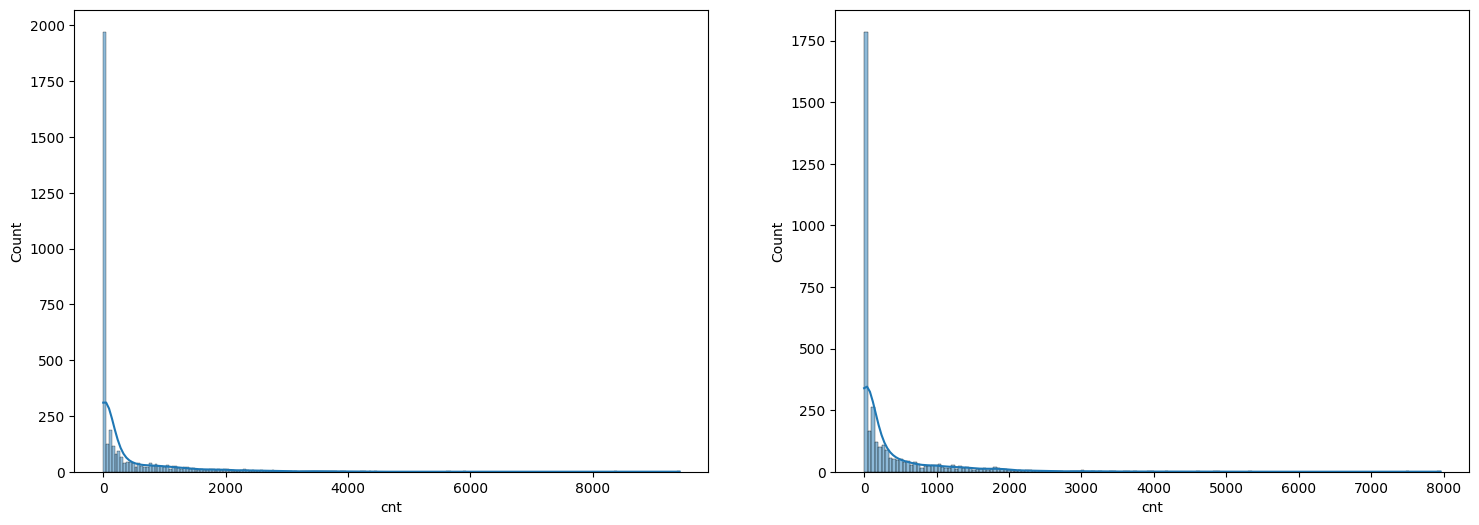

In [364]:
fig, ax = plt.subplots(1,2, figsize=(18, 6))
sns.histplot(counters_in.cnt, kde=True, ax=ax[0])
sns.histplot(counters_out.cnt, kde=True, ax=ax[1])

In [365]:
counters_in = counters_in.asfreq(freq='30min')
counters_out = counters_out.asfreq(freq='30min')

In [366]:
def accumulate_flow(feature:pd.Series) -> List[int]:
    accumulator = []
    cumulative_sum = 0
    
    for flow in feature:
        cumulative_sum += flow
        accumulator.append(cumulative_sum)
        
    return accumulator

In [367]:
counters_in['cumulative_flow'] = accumulate_flow(counters_in.cnt)
counters_out['cumulative_flow'] = accumulate_flow(counters_out.cnt)

In [368]:
counters_train = pd.DataFrame(columns=['dt', 'cnt'])

counters_train['dt'] = counters_in.index
counters_train['cnt'] = counters_in.cumulative_flow.values - counters_out.cumulative_flow.values

counters_train = counters_train.set_index('dt')

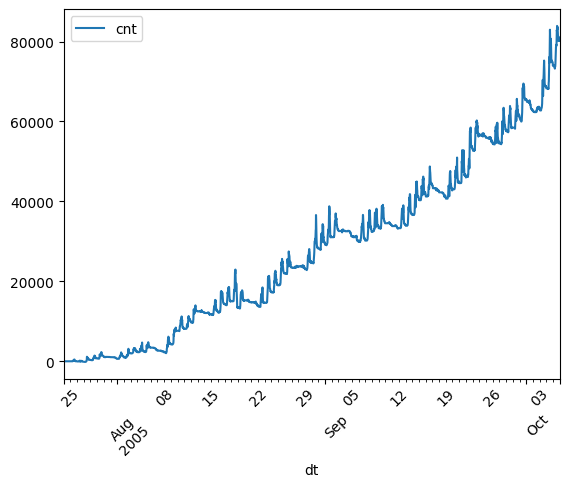

In [369]:
counters_train.plot(rot=45);

In [370]:
counters_train = counters_train.asfreq(freq='30min')

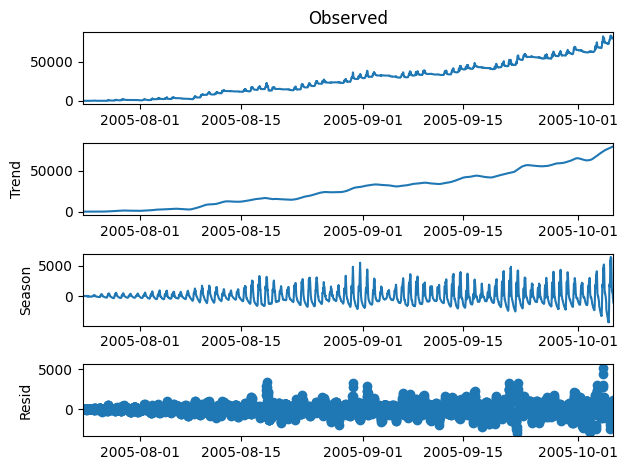

In [371]:
stl_res = STL(counters_train, period=24*2).fit()
stl_res.plot();

In [372]:
events.head(5)

,dt_start,dt_end,event_type
0,2005-07-26 11:00:00,2005-07-26 14:00:00,event
1,2005-07-29 08:00:00,2005-07-29 11:00:00,event
2,2005-08-02 15:30:00,2005-08-02 16:30:00,event
3,2005-08-04 16:30:00,2005-08-04 17:30:00,event
4,2005-08-05 08:00:00,2005-08-05 11:00:00,event


In [24]:
def check_if_event(timestamp) -> int:
    for i in range(len(events)):
        if events.iloc[i]['dt_start'] <= timestamp <= events.iloc[i]['dt_end']:
            return 1
    return 0

In [374]:
events['dt_start'] = events.dt_start.apply(pd.to_datetime)
events['dt_end'] = events.dt_end.apply(pd.to_datetime)

In [375]:
train_dataset = pd.DataFrame(columns=['dt', 'seasonal_feature_transformed', 'event'])

train_dataset['dt'] = counters_train.index
train_dataset['seasonal_feature_transformed'] = np.log(stl_res.seasonal.values - np.min(stl_res.seasonal) + 1)
train_dataset['event'] = train_dataset.dt.apply(check_if_event)

train_dataset = train_dataset.set_index('dt')

In [376]:
train_dataset.head(5)

,seasonal_feature_transformed,event
dt,,
2005-07-24 00:00:00,8.358686,0
2005-07-24 00:30:00,8.356023,0
2005-07-24 01:00:00,8.356937,0
2005-07-24 01:30:00,8.357075,0
2005-07-24 02:00:00,8.357122,0


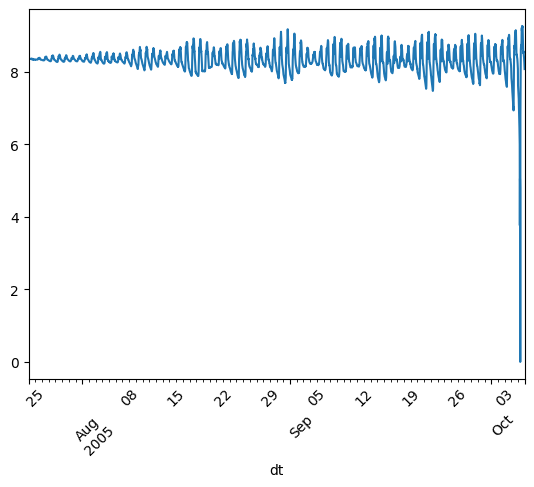

In [377]:
train_dataset.seasonal_feature_transformed.plot(rot=45);

In [378]:
x_train, y_train = train_dataset['seasonal_feature_transformed'].values.reshape(-1, 1), train_dataset['event'].values.reshape(-1, 1)

In [379]:
x_train.shape, y_train.shape

((3552, 1), (3552, 1))

## Test

In [380]:
counters_test = pd.read_csv("../data/counters_test.csv", parse_dates=True)
events = pd.read_csv("../data/events_test.csv", parse_dates=True)

In [381]:
events['dt_start'] = events.dt_start.apply(pd.to_datetime)
events['dt_end'] = events.dt_end.apply(pd.to_datetime)

In [382]:
counters_test['dt'] = counters_test.dt.apply(pd.to_datetime)
counters_test_in = counters_test[counters_test.direction == 'in'][['dt', 'cnt']]
counters_test_out = counters_test[counters_test.direction == 'out'][['dt', 'cnt']]
counters_test_in = counters_test_in.set_index('dt')
counters_test_out = counters_test_out.set_index('dt')

In [383]:
counters_test_in['cumulative_flow'] = accumulate_flow(counters_test_in.cnt)
counters_test_out['cumulative_flow'] = accumulate_flow(counters_test_out.cnt)

In [384]:
counters_test = pd.DataFrame(columns=['dt', 'cnt'])

counters_test['dt'] = counters_test_in.index
counters_test['cnt'] = counters_test_in.cumulative_flow.values - counters_test_out.cumulative_flow.values

counters_test = counters_test.set_index('dt')

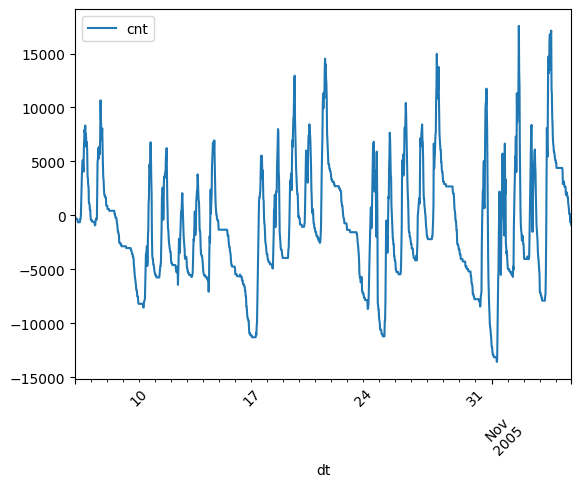

In [385]:
counters_test.plot(rot=45);

In [386]:
counters_test = counters_test.asfreq("30min")

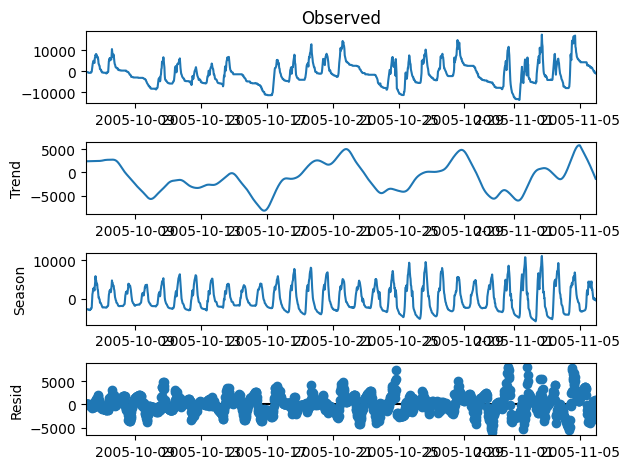

In [387]:
stl_res = STL(counters_test, period=24*2).fit()
stl_res.plot();

In [388]:
test_dataset = pd.DataFrame(columns=['dt', 'seasonal_feature_transformed', 'event'])

test_dataset['dt'] = counters_test.index
test_dataset['seasonal_feature_transformed'] = np.log(stl_res.seasonal.values - np.min(stl_res.seasonal) + 1)
test_dataset['event'] = test_dataset.dt.apply(check_if_event)

test_dataset = test_dataset.set_index("dt")

In [389]:
test_dataset.head(5)

,seasonal_feature_transformed,event
dt,,
2005-10-06 00:00:00,8.102906,0
2005-10-06 00:30:00,8.062117,0
2005-10-06 01:00:00,8.065516,0
2005-10-06 01:30:00,8.049780,0
2005-10-06 02:00:00,8.056085,0


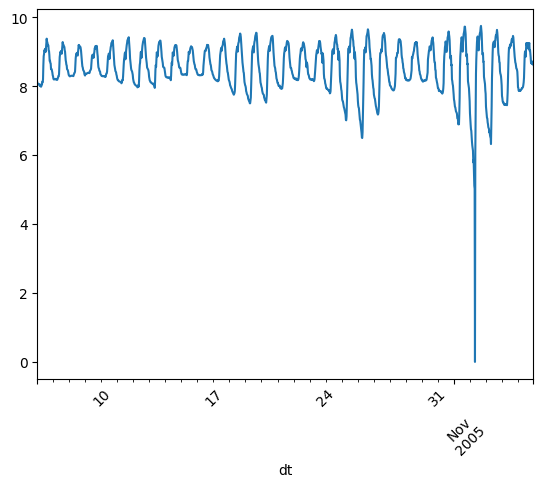

In [390]:
test_dataset.seasonal_feature_transformed.plot(rot=45);

In [391]:
x_test, y_test = test_dataset['seasonal_feature_transformed'].values.reshape(-1, 1), test_dataset['event'].values.reshape(-1, 1)

# Building and fitting model for event prediction

In [392]:
catboost = CatBoostClassifier(depth=5)

catboost.fit(x_train, y_train, 
             silent=True,
             eval_set=(x_test, y_test))

# Event prediction model evaluation and metrics

In [393]:
preds = catboost.predict_proba(x_test)[:, 1]

In [394]:
x_test.shape, y_test.shape

((1488, 1), (1488, 1))

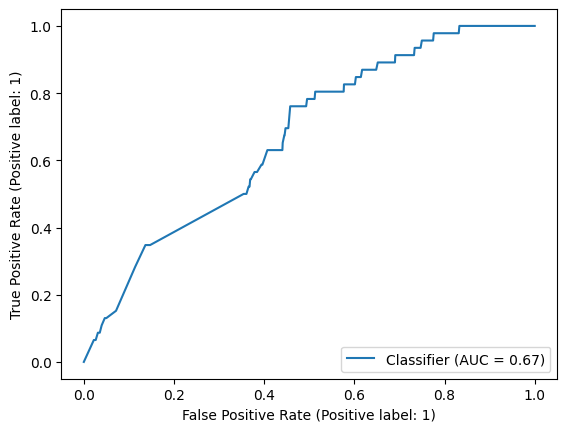

In [395]:
RocCurveDisplay.from_predictions(y_test, preds);

В данной задаче целесообразно максимизировать *ROC-AUC*, т.к в данных наблюдается сильный дисбаланс классов

# Data loading and preprocessing for timeseries prediction

## Train

In [26]:
counters_train = pd.read_csv("../data/counters_train.csv")
events = pd.read_csv("../data/events_train.csv")

In [27]:
counters_train

,dt,direction,cnt
0,2005-07-24 00:00:00,out,0
1,2005-07-24 00:00:00,in,0
2,2005-07-24 00:30:00,out,11
3,2005-07-24 00:30:00,in,0
4,2005-07-24 01:00:00,out,0
...,...,...,...
7099,2005-10-05 22:30:00,in,160
7100,2005-10-05 23:00:00,out,146
7101,2005-10-05 23:00:00,in,0
7102,2005-10-05 23:30:00,out,0


In [28]:
counters_in = counters_train[counters_train.direction == 'in'][['dt', 'cnt']]
counters_out = counters_train[counters_train.direction == 'out'][['dt', 'cnt']]

counters_in['dt'] = counters_in.dt.apply(pd.to_datetime)
counters_out['dt'] = counters_out.dt.apply(pd.to_datetime)

counters_in = counters_in.set_index('dt')
counters_out = counters_out.set_index('dt')

coutners_in  = counters_in.asfreq("30min")
coutners_out  = counters_out.asfreq("30min")

In [35]:
events['dt_start'] = events['dt_start'].apply(pd.to_datetime)
events['dt_end'] = events['dt_end'].apply(pd.to_datetime)

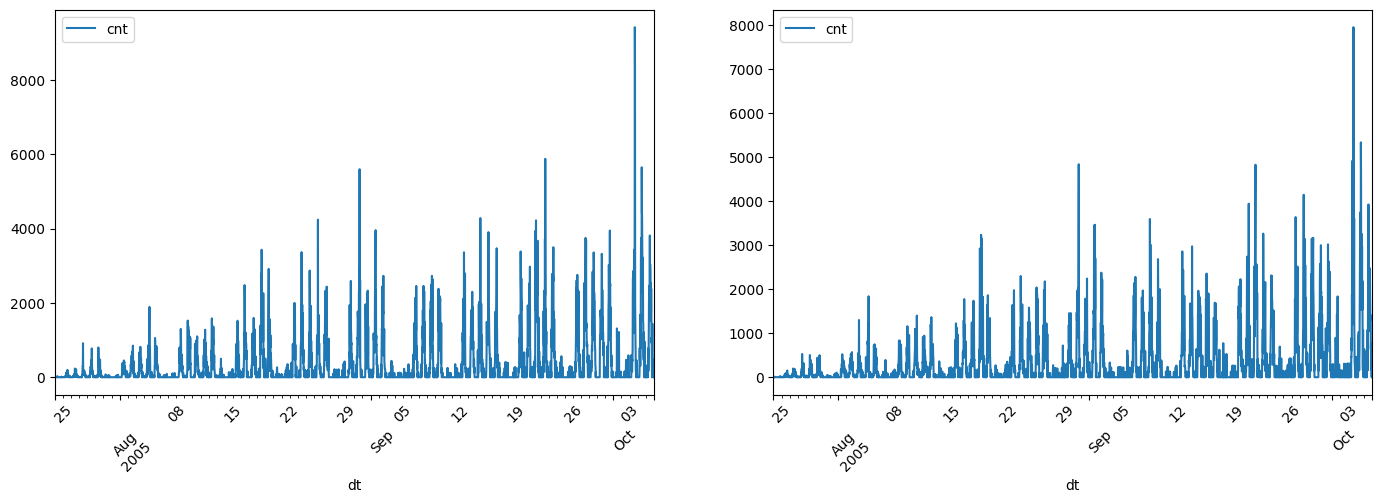

In [29]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
counters_in.plot(rot=45, ax=ax[0])
counters_out.plot(rot=45, ax=ax[1])
plt.show()

### "IN"

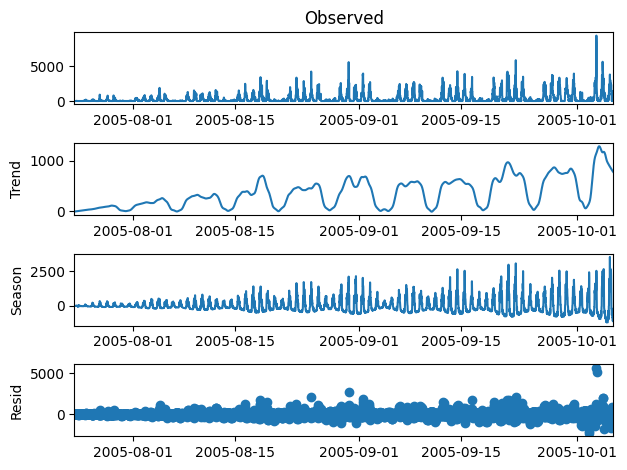

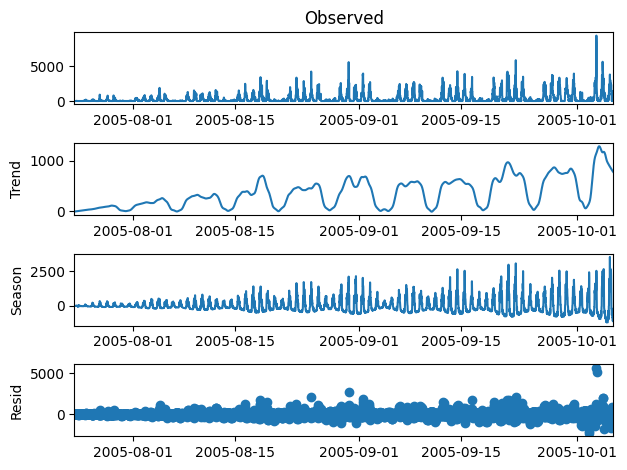

In [30]:
stl_cin = STL(counters_in, period=24*2).fit()
stl_cin.plot()

In [41]:
train_dataset_cnt_in = pd.DataFrame()

train_dataset_cnt_in['dt'] = counters_in.index
train_dataset_cnt_in['seasonal_feature'] = np.log(stl_cin.seasonal.values - np.min(stl_cin.seasonal) + 1)
train_dataset_cnt_in['event'] = train_dataset_cnt_in.dt.apply(check_if_event)
train_dataset_cnt_in['cnt'] = counters_in.cnt.values
train_dataset_cnt_in = train_dataset_cnt_in.set_index('dt')

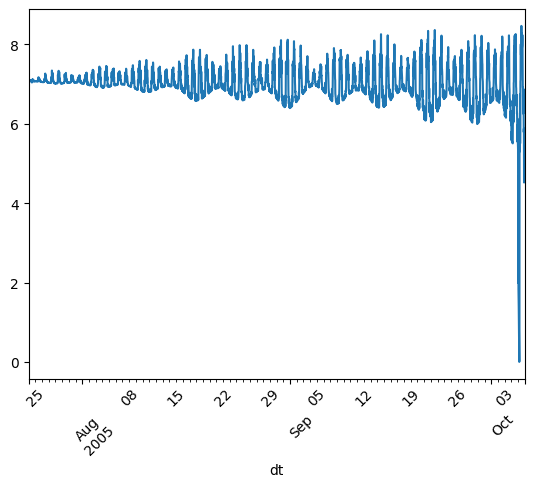

In [44]:
train_dataset_cnt_in.seasonal_feature.plot(rot=45);

In [59]:
train_dataset_cnt_in

,seasonal_feature,event,cnt
dt,,,
2005-07-24 00:00:00,7.087210,0,0
2005-07-24 00:30:00,7.086099,0,0
2005-07-24 01:00:00,7.086582,0,0
2005-07-24 01:30:00,7.086257,0,0
2005-07-24 02:00:00,7.085923,0,0
...,...,...,...
2005-10-05 21:30:00,4.520814,0,0
2005-10-05 22:00:00,5.432719,0,0
2005-10-05 22:30:00,5.195766,0,160


In [62]:
x_cin_train, y_cin_train = train_dataset_cnt_in[['seasonal_feature', 'event']].values, train_dataset_cnt_in['cnt'].values.reshape(-1, 1)

### "OUT"

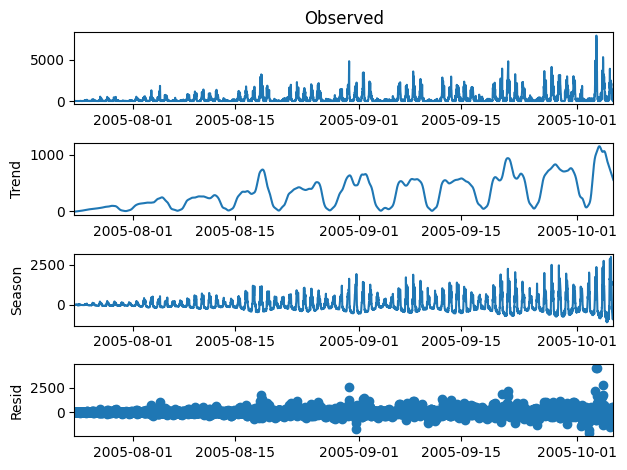

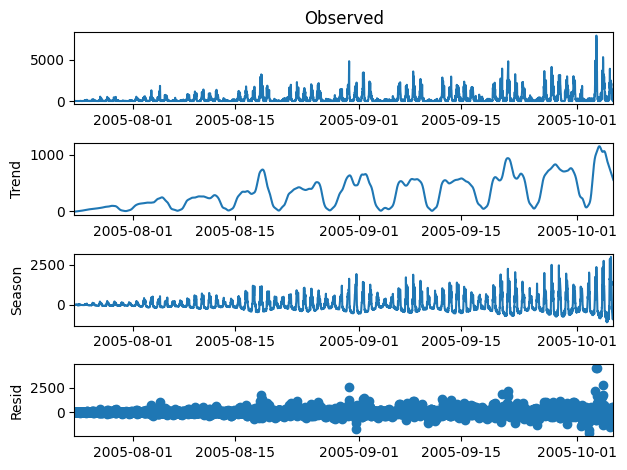

In [45]:
stl_cout = STL(counters_out, period=24*2).fit()
stl_cout.plot()

In [46]:
train_dataset_cnt_out = pd.DataFrame()

train_dataset_cnt_out['dt'] = counters_out.index
train_dataset_cnt_out['seasonal_feature'] = np.log(stl_cout.seasonal.values - np.min(stl_cout.seasonal) + 1)
train_dataset_cnt_out['event'] = train_dataset_cnt_out.dt.apply(check_if_event)
train_dataset_cnt_out['cnt'] = counters_out.cnt.values
train_dataset_cnt_out = train_dataset_cnt_out.set_index('dt')

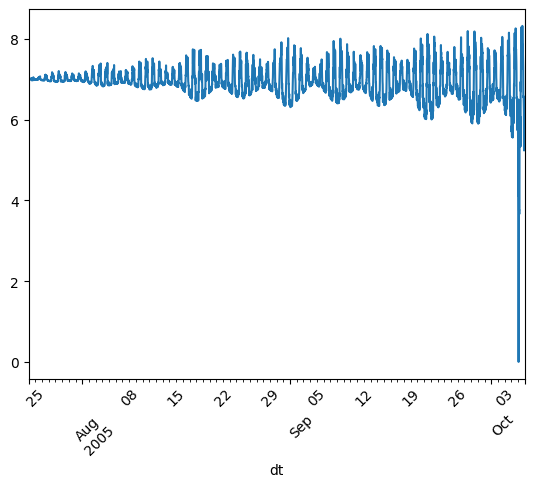

In [ ]:
train_dataset_cnt_out.seasonal_feature.plot(rot=45);

In [63]:
x_train_cout, y_train_cout = train_dataset_cnt_out[['seasonal_feature', 'event']].values, train_dataset_cnt_out['cnt'].values.reshape(-1, 1)

## Test

In [48]:
counters_test = pd.read_csv("../data/counters_test.csv")
events = pd.read_csv("../data/events_test.csv")

In [49]:
counters_test

,dt,direction,cnt
0,2005-10-06 00:00:00,out,164
1,2005-10-06 00:00:00,in,0
2,2005-10-06 00:30:00,out,162
3,2005-10-06 00:30:00,in,0
4,2005-10-06 01:00:00,out,0
...,...,...,...
2971,2005-11-05 22:30:00,in,0
2972,2005-11-05 23:00:00,out,0
2973,2005-11-05 23:00:00,in,0
2974,2005-11-05 23:30:00,out,251


In [50]:
counters_in = counters_test[counters_test.direction == 'in'][['dt', 'cnt']]
counters_out = counters_test[counters_test.direction == 'out'][['dt', 'cnt']]

counters_in['dt'] = counters_in.dt.apply(pd.to_datetime)
counters_out['dt'] = counters_out.dt.apply(pd.to_datetime)

counters_in = counters_in.set_index('dt')
counters_out = counters_out.set_index('dt')

coutners_in  = counters_in.asfreq("30min")
coutners_out  = counters_out.asfreq("30min")

In [51]:
events['dt_start'] = events['dt_start'].apply(pd.to_datetime)
events['dt_end'] = events['dt_end'].apply(pd.to_datetime)

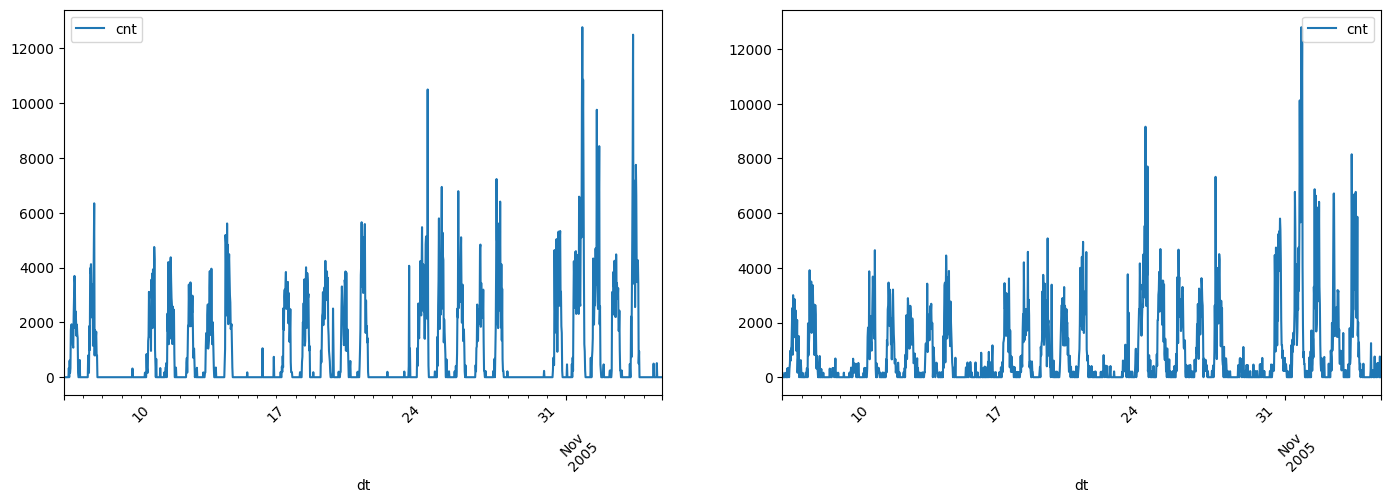

In [52]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
counters_in.plot(rot=45, ax=ax[0])
counters_out.plot(rot=45, ax=ax[1])
plt.show()

### "IN"

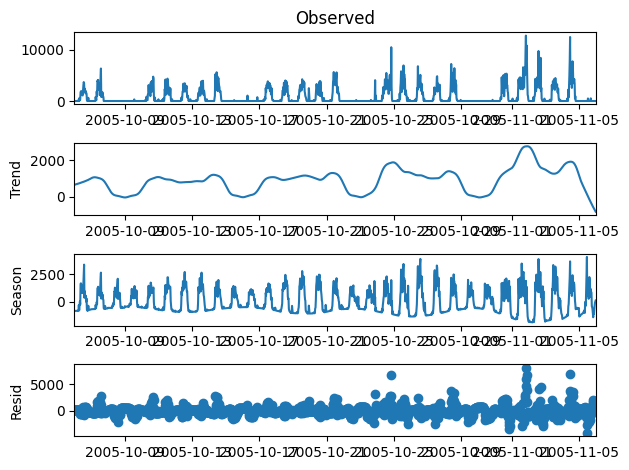

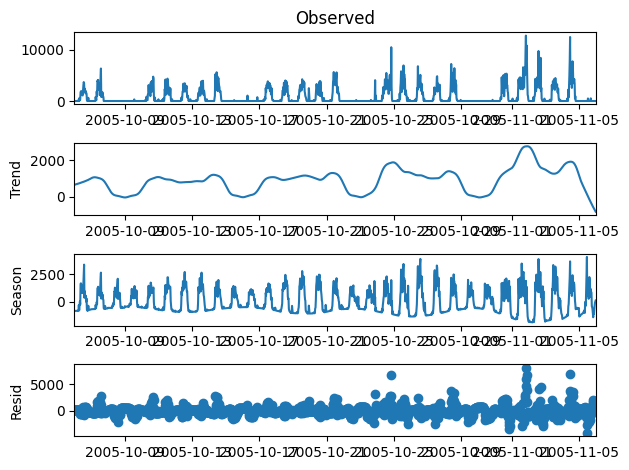

In [53]:
stl_cin = STL(counters_in, period=24*2).fit()
stl_cin.plot()

In [54]:
test_dataset_cnt_in = pd.DataFrame()

test_dataset_cnt_in['dt'] = counters_in.index
test_dataset_cnt_in['seasonal_feature'] = np.log(stl_cin.seasonal.values - np.min(stl_cin.seasonal) + 1)
test_dataset_cnt_in['event'] = test_dataset_cnt_in.dt.apply(check_if_event)
test_dataset_cnt_in['cnt'] = counters_in.cnt.values
test_dataset_cnt_in = test_dataset_cnt_in.set_index('dt')

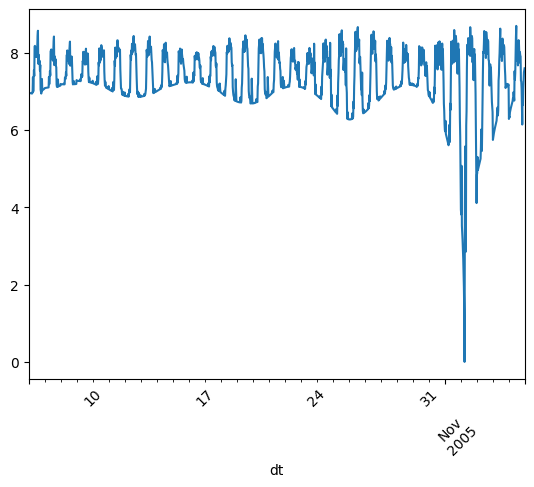

In [55]:
test_dataset_cnt_in.seasonal_feature.plot(rot=45);

In [64]:
x_cin_test, y_cin_test = test_dataset_cnt_in[['seasonal_feature', 'event']].values, test_dataset_cnt_in['cnt'].values.reshape(-1, 1)

### "OUT"

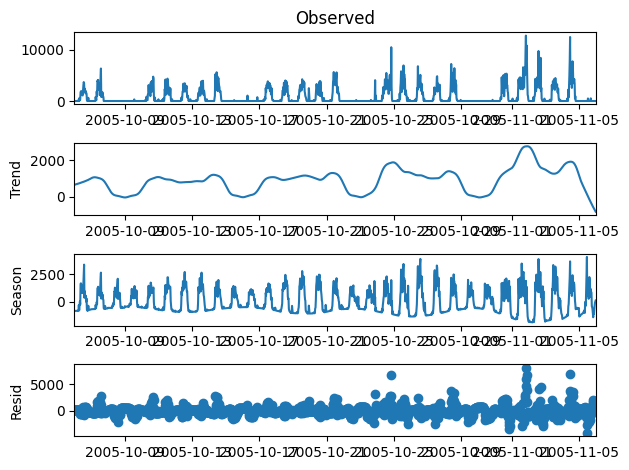

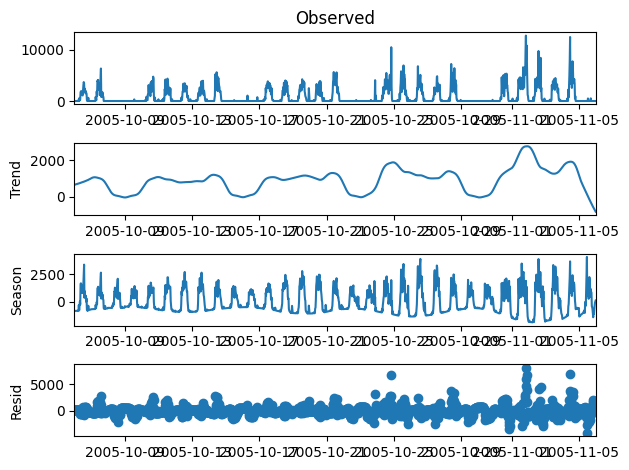

In [ ]:
stl_cout = STL(counters_in, period=24*2).fit()
stl_cout.plot()

In [57]:
test_dataset_cnt_out = pd.DataFrame()

test_dataset_cnt_out['dt'] = counters_out.index
test_dataset_cnt_out['seasonal_feature'] = np.log(stl_cout.seasonal.values - np.min(stl_cout.seasonal) + 1)
test_dataset_cnt_out['event'] = test_dataset_cnt_out.dt.apply(check_if_event)
test_dataset_cnt_out['cnt'] = counters_out.cnt.values
test_dataset_cnt_out = test_dataset_cnt_out.set_index('dt')

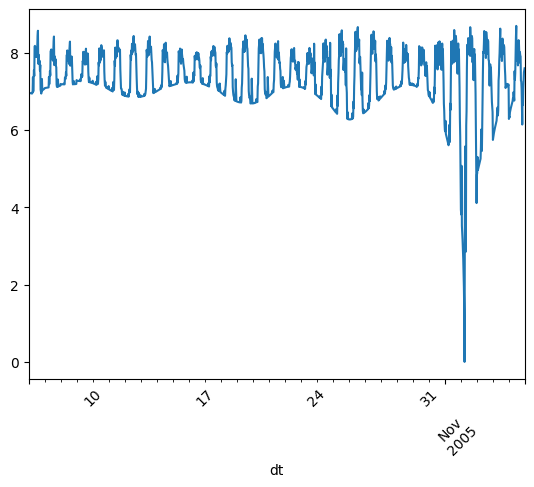

In [58]:
test_dataset_cnt_out.seasonal_feature.plot(rot=45);

In [65]:
x_test_cout, y_test_cout = test_dataset_cnt_out[['seasonal_feature', 'event']].values, test_dataset_cnt_out['cnt'].values.reshape(-1, 1)

# Building models for flow prediction

## "IN"

In [66]:
DEPTH = 5

In [67]:
catboost_cin = CatBoostRegressor(depth=DEPTH)

catboost_cin.fit(x_cin_train, y_cin_train, 
                 eval_set=(x_cin_test, y_cin_test))

Learning rate set to 0.062133
0:	learn: 687.6831993	test: 1662.3521919	best: 1662.3521919 (0)	total: 46.4ms	remaining: 46.4s
1:	learn: 661.9993396	test: 1613.7730586	best: 1613.7730586 (1)	total: 46.8ms	remaining: 23.4s
2:	learn: 637.5017246	test: 1573.4389297	best: 1573.4389297 (2)	total: 47.2ms	remaining: 15.7s
3:	learn: 614.5590279	test: 1534.5771615	best: 1534.5771615 (3)	total: 47.6ms	remaining: 11.9s
4:	learn: 594.2810177	test: 1500.8488882	best: 1500.8488882 (4)	total: 48ms	remaining: 9.54s
5:	learn: 575.0894180	test: 1468.5719695	best: 1468.5719695 (5)	total: 48.4ms	remaining: 8.01s
6:	learn: 556.8771562	test: 1440.0495840	best: 1440.0495840 (6)	total: 48.7ms	remaining: 6.91s
7:	learn: 540.9736653	test: 1413.5913982	best: 1413.5913982 (7)	total: 49.1ms	remaining: 6.09s
8:	learn: 526.0707711	test: 1389.8977955	best: 1389.8977955 (8)	total: 49.5ms	remaining: 5.45s
9:	learn: 512.2435538	test: 1368.0923569	best: 1368.0923569 (9)	total: 49.9ms	remaining: 4.94s
10:	learn: 499.6206535

In [71]:
preds = catboost_cin.predict(x_cin_test) + stl_cin.trend.values

mae(y_cin_test, preds)

1229.4682584451552

In [72]:
preds

array([706.24448341, 708.91099138, 714.51348197, ..., 154.31888985,
       374.16843095, 510.24750429])